In [1]:
# Get info of One Model evals (without fine-tuned G-Retriever)

import os
import json

path = "Model Outpus & Evaluation/One Model Evaluation/"
files_to_data = dict()

for f_name in os.listdir(path):
    with open(f"{path}/{f_name}", 'r') as f:
        data = f.readlines()
        data = [json.loads(x) for x in data]
    
    files_to_data[f_name] = data

unique_files = [x[:-7] for x in list(files_to_data.keys())]
unique_files = list(set(unique_files))

In [2]:
import pandas as pd
import re

rag_df = pd.DataFrame()
g_retr_df = pd.DataFrame()
ft_df = pd.DataFrame()

f_name_to_scores = dict()

for f_name in unique_files:
    scores_list = list()
    for q_id in range(len(files_to_data[f_name+ '1.jsonl'])):
        score = list()
        for i in range(1, 4):
            f_name_with_number = f"{f_name}{i}.jsonl"
            score.append(
                int(files_to_data[f_name_with_number][q_id]['score'])
            )
        scores_list.append(
            sum(score) / 3
        )
    f_name_to_scores[f_name] = scores_list

    count = re.findall(r"\d+", f_name)[0]

    if "FT" in f_name:
        ft_df[str(count)] = scores_list
    elif "RAG" in f_name:
        rag_df[str(count)] = scores_list
    else:
        g_retr_df[str(count)] = scores_list

In [3]:
sorted_vals = list(map(str,sorted(map(int, g_retr_df.columns))))

rag_df = rag_df.reindex(sorted_vals, axis=1)
g_retr_df = g_retr_df.reindex(sorted_vals, axis=1)

rag_df['category'] = ['syntax'] * 140 + ['dependencies'] * 135 + ['meta'] * 50
rag_df['type'] = ['RAG']*325

g_retr_df['category'] = ['syntax'] * 140 + ['dependencies'] * 135 + ['meta'] * 50
g_retr_df['type'] = ['G-Retriever']*325

ft_df['category'] = ['syntax'] * 56 + ['dependencies'] * 54 + ['meta'] * 20

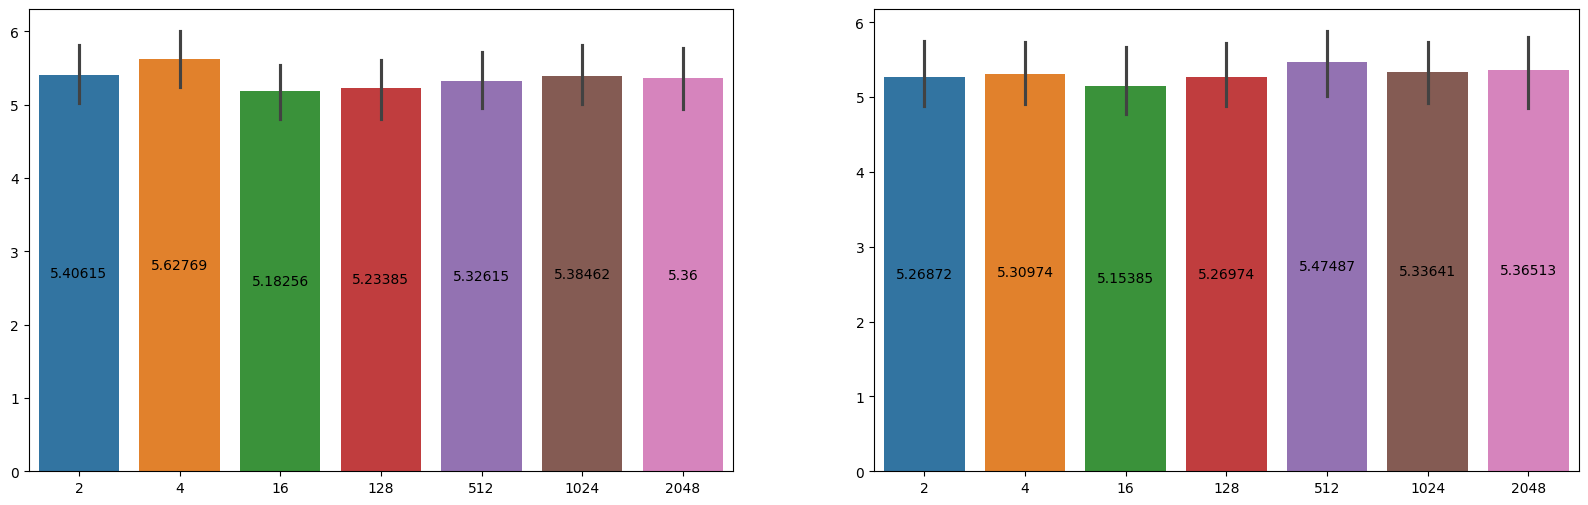

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,2, figsize=(20, 6))

ax1 = sns.barplot(g_retr_df, errorbar=('ci', 100), ax=ax[0])
for con in ax1.containers:
    ax1.bar_label(con, label_type='center')

ax2 = sns.barplot(rag_df, errorbar=('ci', 100), ax=ax[1])
for con in ax2.containers:
    ax2.bar_label(con, label_type='center')

             type category variable     value
0             RAG   syntax        2  6.000000
1             RAG   syntax        2  7.666667
2             RAG   syntax        2  8.666667
3             RAG   syntax        2  4.666667
4             RAG   syntax        2  4.666667
...           ...      ...      ...       ...
4545  G-Retriever     meta     2048  2.000000
4546  G-Retriever     meta     2048  3.000000
4547  G-Retriever     meta     2048  8.666667
4548  G-Retriever     meta     2048  7.666667
4549  G-Retriever     meta     2048  3.666667

[4550 rows x 4 columns]


<Axes: xlabel='variable', ylabel='value'>

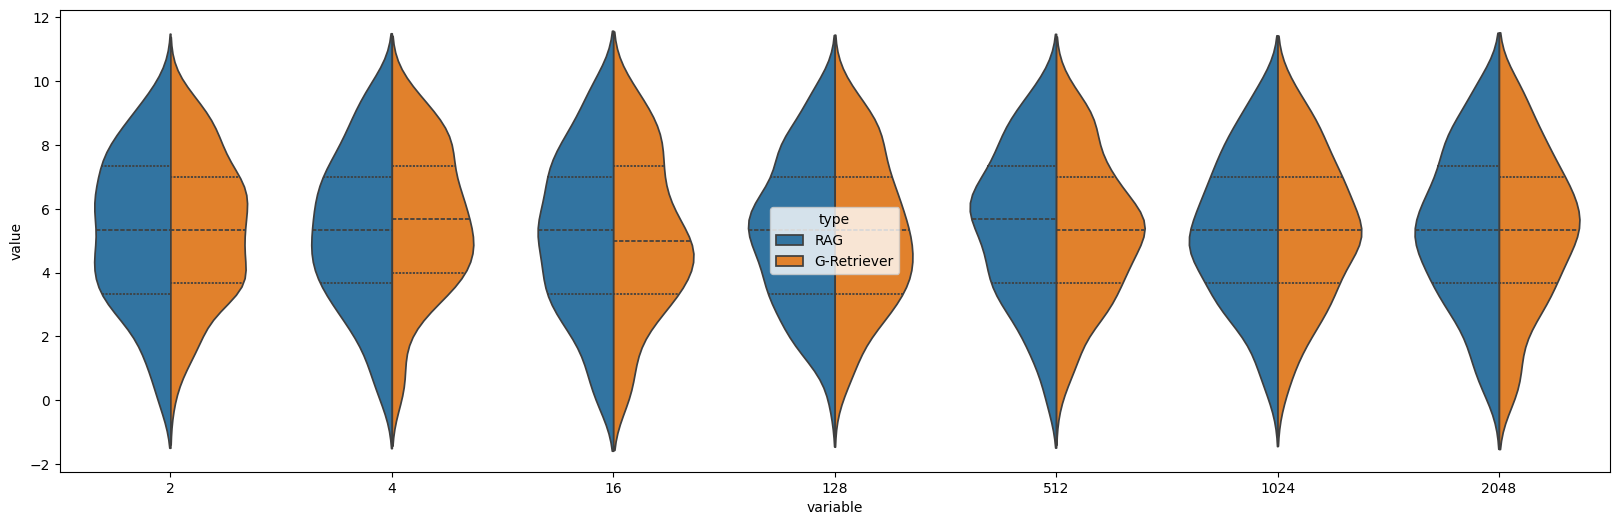

In [5]:
df_full = pd.concat([rag_df, g_retr_df], axis=0)
df_full = pd.melt(df_full, id_vars=['type', 'category'])

print(df_full)

fig, ax = plt.subplots(1, 1, figsize=(20, 6))
sns.violinplot(df_full,
               x='variable',
               y='value',
               hue="type",
               split=True, inner='quart', gridsize=50, ax=ax)

2         4        16       128       512  \
type        category                                                         
G-Retriever dependencies  4.728395  4.950617  4.545679  4.459259  4.664198   
            meta          6.206667  6.273333  5.800000  6.013333  6.100000   
            syntax        5.773810  6.050000  5.576190  5.702381  5.688095   
RAG         dependencies  4.614815  4.713580  4.365432  4.548148  4.827160   
            meta          6.320000  6.246667  6.273333  6.240000  6.060000   
            syntax        5.523810  5.550000  5.514286  5.619048  5.890476   

                              1024      2048  
type        category                          
G-Retriever dependencies  4.911111  4.967901  
            meta          5.826667  5.973333  
            syntax        5.683333  5.519048  
RAG         dependencies  4.590123  4.893827  
            meta          5.840000  6.240000  
            syntax        5.876190  5.507143

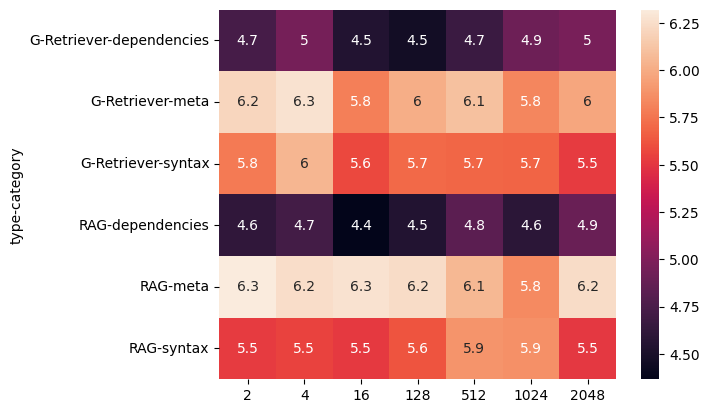

In [6]:
sns.heatmap(
    pd.concat([rag_df, g_retr_df]).groupby(['type', 'category']).mean(),
    annot=True
)

pd.concat([rag_df, g_retr_df]).groupby(['type', 'category']).mean()

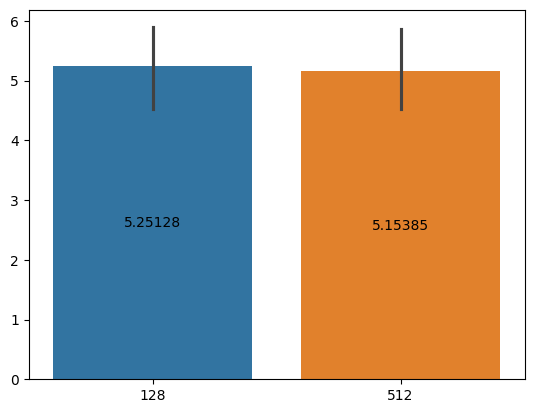

In [7]:
ax1 = sns.barplot(ft_df, errorbar=('ci', 100))
for con in ax1.containers:
    ax1.bar_label(con, label_type='center')

<Axes: ylabel='category'>

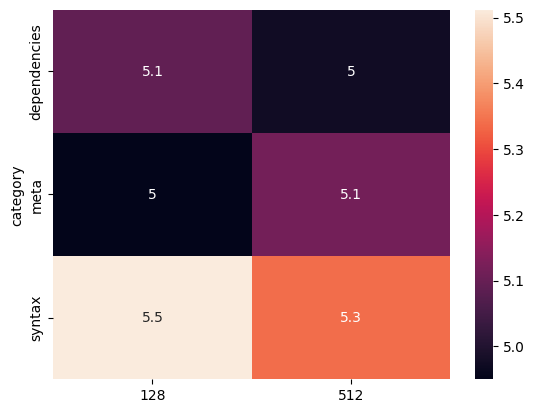

In [8]:
sns.heatmap(
    ft_df.groupby('category').mean(),
    annot=True
)

# Model vs Model evaluation

    type     variable      value
0      2          RAG  24.461538
1      4          RAG  18.461538
2     16          RAG  17.076923
3    128          RAG  18.461538
4    512          RAG  21.230769
5   1024          RAG  18.923077
6   2048          RAG  16.000000
7      2  G-Retriever  17.230769
8      4  G-Retriever  17.692308
9     16  G-Retriever  18.461538
10   128  G-Retriever  21.076923
11   512  G-Retriever  18.615385
12  1024  G-Retriever  16.307692
13  2048  G-Retriever  15.384615
14     2     Tie good  21.846154
15     4     Tie good  22.769231
16    16     Tie good  22.307692
17   128     Tie good  22.000000
18   512     Tie good  25.230769
19  1024     Tie good  27.076923
20  2048     Tie good  31.384615
21     2      Tie bad  36.461538
22     4      Tie bad  41.076923
23    16      Tie bad  42.153846
24   128      Tie bad  38.461538
25   512      Tie bad  34.923077
26  1024      Tie bad  37.692308
27  2048      Tie bad  37.230769


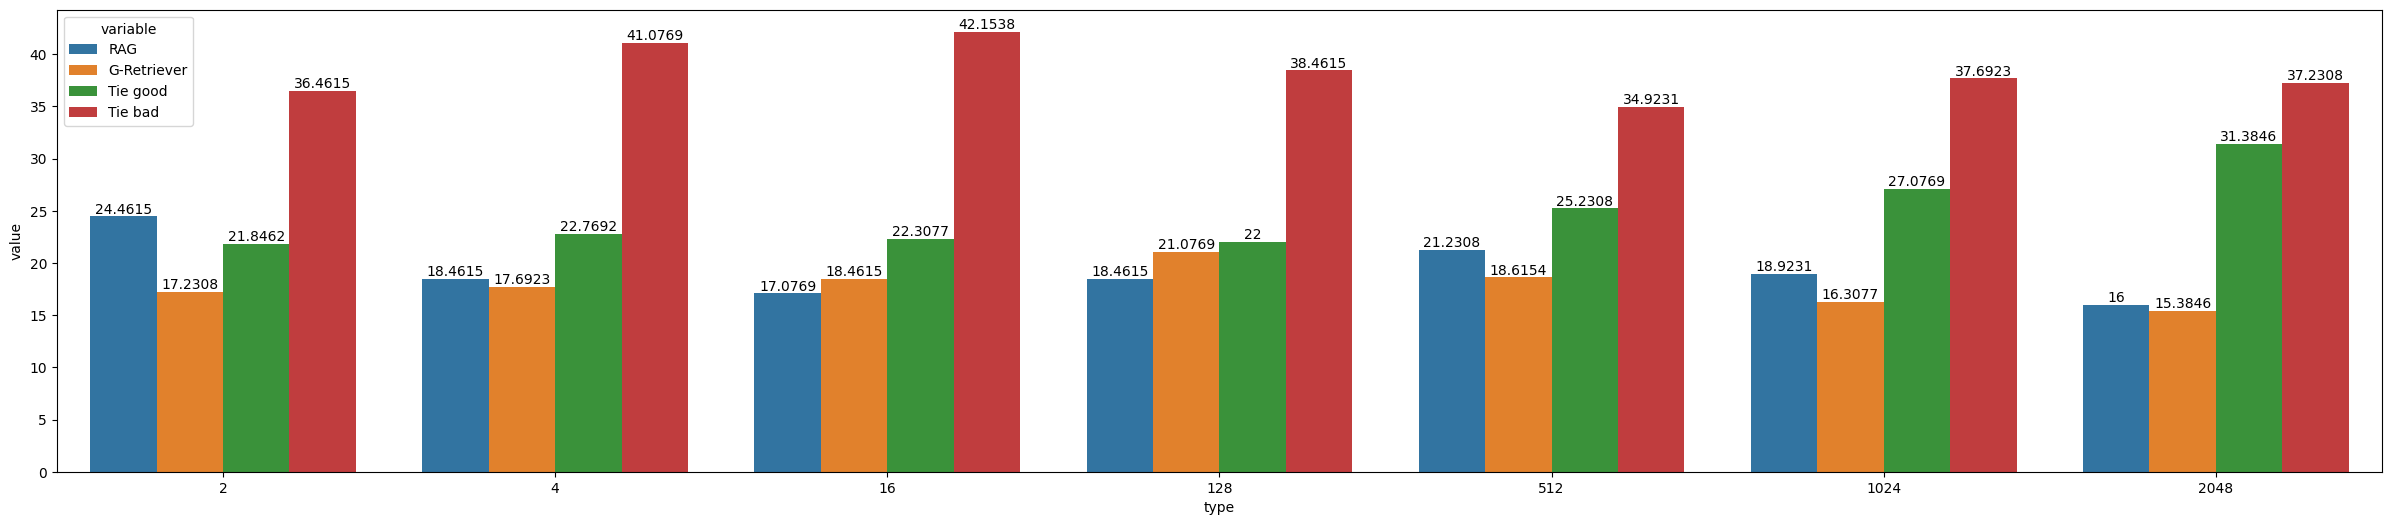

In [9]:
from collections import Counter
import json
import os
import pandas as pd
import seaborn as sns

path = "Model Outpus & Evaluation/Model vs Model Evaluation"
file_names = sorted(os.listdir(path))

f_name_to_scores = dict()
for fname in file_names:
    with open(f"{path}/{fname}") as f:
        data = f.readlines()
        data = [json.loads(x)['verdict'] for x in data]

    f_name_to_scores[fname] = dict(Counter(data))

# Collecting the data in the format:
# <RAG is better>, <G-Retriever is better>, <Both assistants are good>, <Both assistants are bad>

results_df = pd.DataFrame(columns=["type", "RAG", "G-Retriever", "Tie good", "Tie bad"])

for i in range(0, 14, 2):
    type = file_names[i].split()[1]

    g_retr_vs_rag = f_name_to_scores[file_names[i]]
    rag_vs_g_retr = f_name_to_scores[file_names[i+1]]

    num_scores = sum(list(g_retr_vs_rag.values()))

    g_retr   = 100 * ( g_retr_vs_rag["Assistant A's answer is better"] + rag_vs_g_retr["Assistant B's answer is better"] ) / (2*num_scores)
    rag      = 100 * ( g_retr_vs_rag["Assistant B's answer is better"] + rag_vs_g_retr["Assistant A's answer is better"] ) / (2*num_scores)
    tie_good = 100 * ( g_retr_vs_rag["Both assistants are good"] + rag_vs_g_retr["Both assistants are good"] ) / (2*num_scores)
    tie_bad  = 100 * ( g_retr_vs_rag["Both assistants are bad"] + rag_vs_g_retr["Both assistants are bad"] ) / (2*num_scores)

    results_df.loc[len(results_df)] = (type, rag, g_retr, tie_good, tie_bad)

results_df = results_df.melt('type')

print(results_df)

f, ax = plt.subplots(1, 1, figsize=(30, 6))
sns.barplot(results_df, x="type", y="value", hue="variable", ax=ax)

for con in ax.containers:
    ax.bar_label(con)

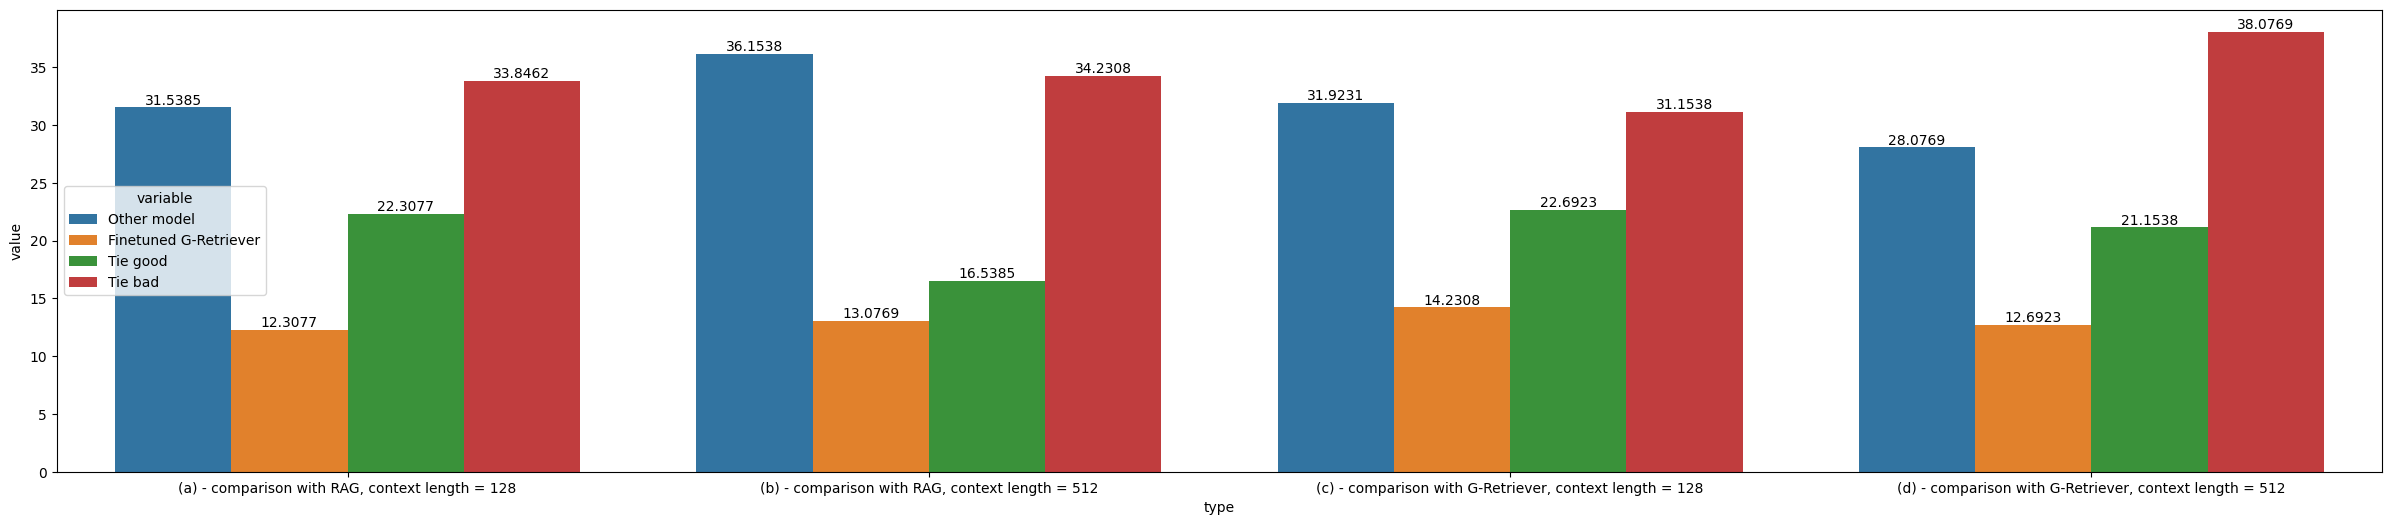

In [10]:
results_ft_df = pd.DataFrame(columns=["type", "Other model", "Finetuned G-Retriever", "Tie good", "Tie bad"])

descriptions = [
    "(a) - comparison with RAG, context length = 128",
    "(b) - comparison with RAG, context length = 512",
    "(c) - comparison with G-Retriever, context length = 128",
    "(d) - comparison with G-Retriever, context length = 512",
]

for i, description in zip(range(14, 24, 2), descriptions):
    rag_vs_g_retr = f_name_to_scores[file_names[i]]
    g_retr_vs_rag = f_name_to_scores[file_names[i+1]]

    num_scores = sum(list(g_retr_vs_rag.values()))

    g_retr   = 100 * ( g_retr_vs_rag["Assistant A's answer is better"] + rag_vs_g_retr["Assistant B's answer is better"] ) / (2*num_scores)
    other    = 100 * ( g_retr_vs_rag["Assistant B's answer is better"] + rag_vs_g_retr["Assistant A's answer is better"] ) / (2*num_scores)
    tie_good = 100 * ( g_retr_vs_rag["Both assistants are good"]       + rag_vs_g_retr["Both assistants are good"] )       / (2*num_scores)
    tie_bad  = 100 * ( g_retr_vs_rag["Both assistants are bad"]        + rag_vs_g_retr["Both assistants are bad"] )        / (2*num_scores)

    results_ft_df.loc[len(results_ft_df)] = (description, other, g_retr, tie_good, tie_bad)

results_ft_df = results_ft_df.melt('type')

f, ax = plt.subplots(1, 1, figsize=(30, 6))
sns.barplot(results_ft_df, x="type", y="value", hue="variable", ax=ax)

for con in ax.containers:
    ax.bar_label(con)

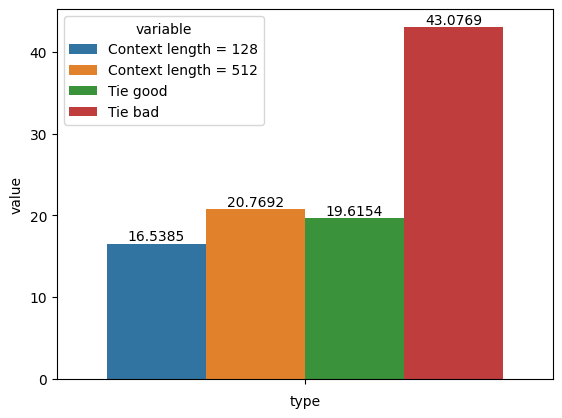

In [11]:
results_ft_df = pd.DataFrame(columns=["type", "Context length = 128", "Context length = 512", "Tie good", "Tie bad"])

rag_vs_g_retr = f_name_to_scores[file_names[-2]]
g_retr_vs_rag = f_name_to_scores[file_names[-1]]

num_scores = sum(list(g_retr_vs_rag.values()))

g_retr   = 100 * ( g_retr_vs_rag["Assistant A's answer is better"] + rag_vs_g_retr["Assistant B's answer is better"] ) / (2*num_scores)
other    = 100 * ( g_retr_vs_rag["Assistant B's answer is better"] + rag_vs_g_retr["Assistant A's answer is better"] ) / (2*num_scores)
tie_good = 100 * ( g_retr_vs_rag["Both assistants are good"]       + rag_vs_g_retr["Both assistants are good"] )       / (2*num_scores)
tie_bad  = 100 * ( g_retr_vs_rag["Both assistants are bad"]        + rag_vs_g_retr["Both assistants are bad"] )        / (2*num_scores)

results_ft_df.loc[len(results_ft_df)] = ("", other, g_retr, tie_good, tie_bad)

results_ft_df = results_ft_df.melt('type')

# f, ax = plt.subplots(1, 1, figsize=(30, 6))
ax = sns.barplot(results_ft_df, x="type", y="value", hue="variable")

for con in ax.containers:
    ax.bar_label(con)

# Model vs Model with question categories (Syntax, Dependencies, and Meta)

    Type      Category        RAG  G-Retriever   Tie good    Tie bad
0      2        Syntax  29.285714    21.785714  20.000000  28.928571
1      2  Dependencies  18.888889    15.185185  18.148148  47.777778
2      2          Meta  26.000000    10.000000  37.000000  27.000000
3      4        Syntax  21.428571    20.714286  18.214286  39.642857
4      4  Dependencies  14.444444    11.851852  24.074074  49.629630
5      4          Meta  21.000000    25.000000  32.000000  22.000000
6     16        Syntax  22.142857    18.571429  19.285714  40.000000
7     16  Dependencies  12.592593    16.666667  22.962963  47.777778
8     16          Meta  15.000000    23.000000  29.000000  33.000000
9    128        Syntax  20.714286    23.928571  22.142857  33.214286
10   128  Dependencies  16.666667    18.518519  18.148148  46.666667
11   128          Meta  17.000000    20.000000  32.000000  31.000000
12   512        Syntax  23.214286    22.142857  25.714286  28.928571
13   512  Dependencies  17.777778 

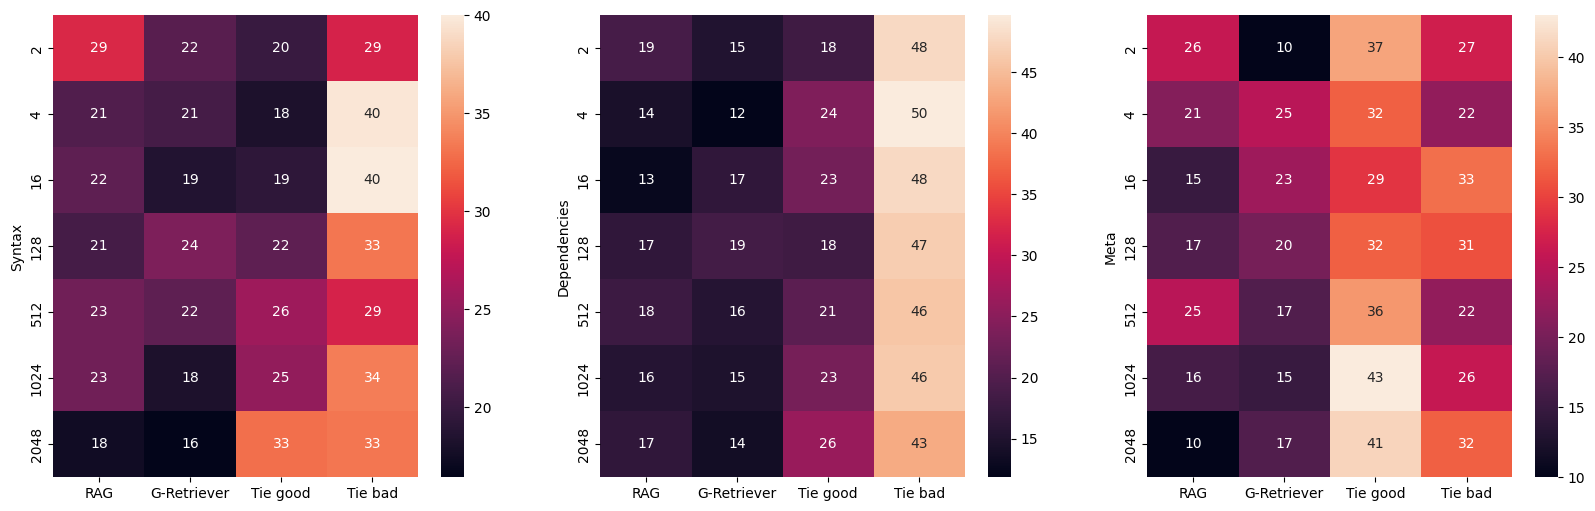

In [12]:
from collections import Counter
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

path = "Model Outpus & Evaluation/Model vs Model Evaluation"
file_names = sorted(os.listdir(path))

f_name_to_scores = dict()
for fname in file_names:
    with open(f"{path}/{fname}") as f:
        data = f.readlines()
        data = [json.loads(x)['verdict'] for x in data]

    f_name_to_scores[fname] = data

# Collecting the data in the format:
# <RAG is better>, <G-Retriever is better>, <Both assistants are good>, <Both assistants are bad>

results_df = pd.DataFrame(columns=["Type", "Category", "RAG", "G-Retriever", "Tie good", "Tie bad"])
categories = ["Syntax", "Dependencies", "Meta"]
slices = [slice(0, 140), slice(140, 275), slice(275, 325)]

for i in range(0, 14, 2):
    type = file_names[i].split()[1]

    for cat, sli in zip(categories, slices):
        
        g_retr_vs_rag = f_name_to_scores[file_names[i]][sli]
        rag_vs_g_retr = f_name_to_scores[file_names[i+1]][sli]

        g_retr_vs_rag = dict(Counter(g_retr_vs_rag))
        rag_vs_g_retr = dict(Counter(rag_vs_g_retr))

        num_scores = sum(list(g_retr_vs_rag.values()))

        g_retr   = 100 * ( g_retr_vs_rag["Assistant A's answer is better"] + rag_vs_g_retr["Assistant B's answer is better"] ) / (2*num_scores)
        rag      = 100 * ( g_retr_vs_rag["Assistant B's answer is better"] + rag_vs_g_retr["Assistant A's answer is better"] ) / (2*num_scores)
        tie_good = 100 * ( g_retr_vs_rag["Both assistants are good"] + rag_vs_g_retr["Both assistants are good"] ) / (2*num_scores)
        tie_bad  = 100 * ( g_retr_vs_rag["Both assistants are bad"] + rag_vs_g_retr["Both assistants are bad"] ) / (2*num_scores)

        results_df.loc[len(results_df)] = (int(type), cat, rag, g_retr, tie_good, tie_bad)

print(results_df)

pl, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, cat in enumerate(categories):
    sns.heatmap(
        results_df.loc[results_df.Category == cat].set_index('Type').drop(['Category'], axis=1),
        annot=True, ax=ax[i])
    ax[i].set_ylabel(cat)

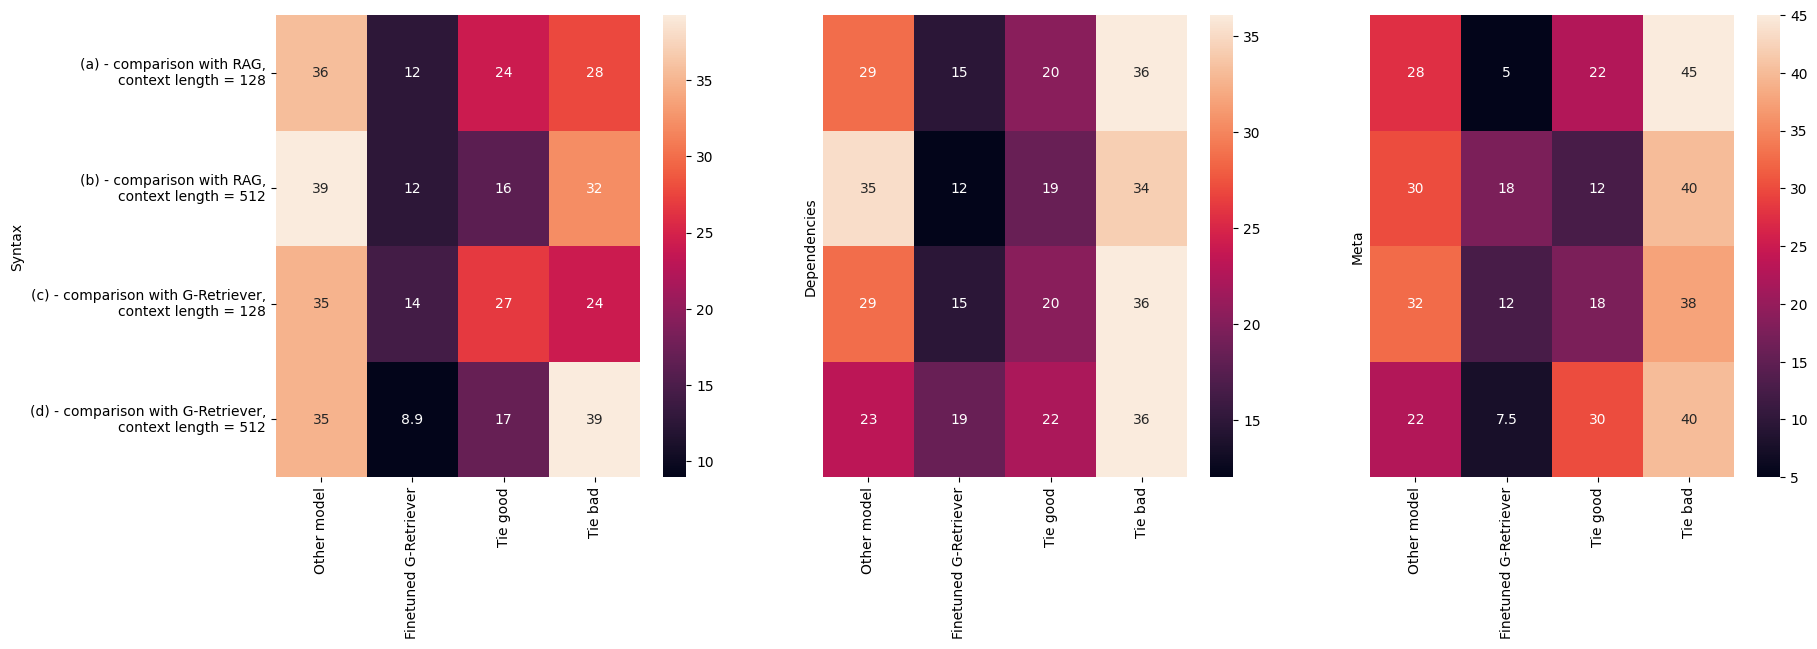

In [13]:
results_ft_df = pd.DataFrame(columns=["Type", "Category", "Other model", "Finetuned G-Retriever", "Tie good", "Tie bad"])

descriptions = [
    "(a) - comparison with RAG,\ncontext length = 128",
    "(b) - comparison with RAG,\ncontext length = 512",
    "(c) - comparison with G-Retriever,\ncontext length = 128",
    "(d) - comparison with G-Retriever,\ncontext length = 512",
]

categories = ["Syntax", "Dependencies", "Meta"]
slices = [slice(0, 56), slice(56, 110), slice(110, 130)]

for i, description in zip(range(14, 24, 2), descriptions):
    
    for cat, sli in zip(categories, slices):
        rag_vs_g_retr = f_name_to_scores[file_names[i]][sli]
        g_retr_vs_rag = f_name_to_scores[file_names[i+1]][sli]

        rag_vs_g_retr = dict(Counter(rag_vs_g_retr))
        g_retr_vs_rag = dict(Counter(g_retr_vs_rag))

        num_scores = sum(list(g_retr_vs_rag.values()))

        g_retr   = 100 * ( g_retr_vs_rag.get("Assistant A's answer is better", 0) + rag_vs_g_retr["Assistant B's answer is better"] ) / (2*num_scores)
        other    = 100 * ( g_retr_vs_rag["Assistant B's answer is better"] + rag_vs_g_retr.get("Assistant A's answer is better", 0) ) / (2*num_scores)
        tie_good = 100 * ( g_retr_vs_rag["Both assistants are good"]       + rag_vs_g_retr["Both assistants are good"] ) / (2*num_scores)
        tie_bad  = 100 * ( g_retr_vs_rag["Both assistants are bad"]        + rag_vs_g_retr["Both assistants are bad"] ) / (2*num_scores)

        results_ft_df.loc[len(results_ft_df)] = (description, cat, other, g_retr, tie_good, tie_bad)

results_ft_df

p, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, cat in enumerate(categories):
    df_to_plot = results_ft_df.loc[results_ft_df.Category == cat].drop(["Category"], axis=1).set_index("Type")
    if i == 0: sns.heatmap(df_to_plot,ax=ax[i], annot=True)
    else:      sns.heatmap(df_to_plot,ax=ax[i], annot=True, yticklabels=[])
    ax[i].set_ylabel(cat)

<Axes: ylabel='Category'>

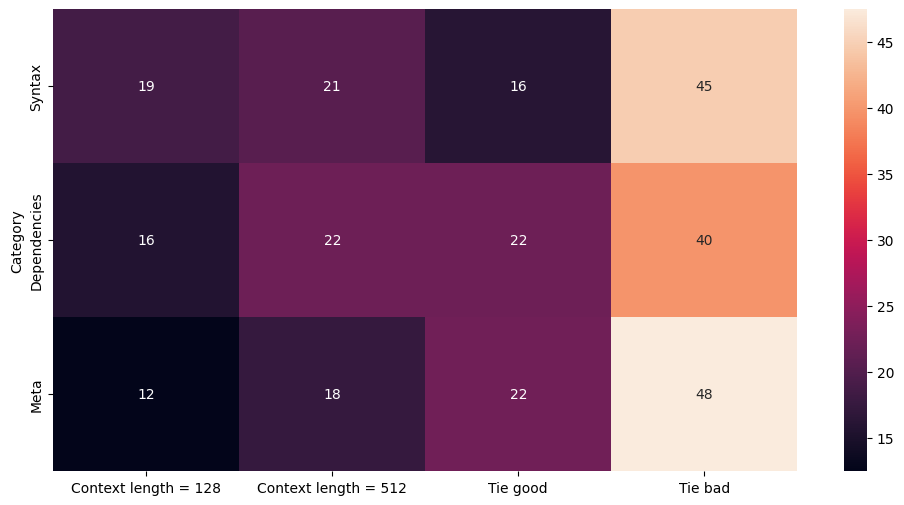

In [14]:
results_ft_df = pd.DataFrame(columns=["Type", "Category", "Context length = 128", "Context length = 512", "Tie good", "Tie bad"])

for cat, sli in zip(categories, slices):
    rag_vs_g_retr = f_name_to_scores[file_names[-2]][sli]
    g_retr_vs_rag = f_name_to_scores[file_names[-1]][sli]

    rag_vs_g_retr = dict(Counter(rag_vs_g_retr))
    g_retr_vs_rag = dict(Counter(g_retr_vs_rag))

    num_scores = sum(list(g_retr_vs_rag.values()))

    g_retr   = 100 * ( g_retr_vs_rag["Assistant A's answer is better"] + rag_vs_g_retr["Assistant B's answer is better"] ) / (2*num_scores)
    other    = 100 * ( g_retr_vs_rag["Assistant B's answer is better"] + rag_vs_g_retr["Assistant A's answer is better"] ) / (2*num_scores)
    tie_good = 100 * ( g_retr_vs_rag["Both assistants are good"]       + rag_vs_g_retr["Both assistants are good"] )       / (2*num_scores)
    tie_bad  = 100 * ( g_retr_vs_rag["Both assistants are bad"]        + rag_vs_g_retr["Both assistants are bad"] )        / (2*num_scores)

    results_ft_df.loc[len(results_ft_df)] = ("", cat, other, g_retr, tie_good, tie_bad)

results_ft_df

p, ax = plt.subplots(1, 1, figsize=(12, 6))
results_ft_df = results_ft_df.set_index('Category').drop(["Type"], axis=1)
sns.heatmap(results_ft_df, annot=True, ax=ax)